In [29]:
# --------------------------------------------------------------
# 1️⃣  Install dependencies (run once)
# --------------------------------------------------------------
!pip install pandas sqlalchemy mysql-connector-python -q

# --------------------------------------------------------------
# 2️⃣  Imports
# --------------------------------------------------------------
import pandas as pd
from sqlalchemy import create_engine

# --------------------------------------------------------------
# 3️⃣  Build the SQLAlchemy engine
# --------------------------------------------------------------
def get_engine():
    user = "studente_dapt"
    password = "Ep1c0d3!!D4t4**4n4lys1s"
    host = "epicode-data-pt-mysql.cvetyjye2qbl.eu-central-1.rds.amazonaws.com"
    port = 3306
    db   = "AdventureWorksDW"

    uri = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(uri, echo=False)   # echo=False disables verbose SQL logging
    return engine

engine = get_engine()          # keep the engine alive for the whole cell

# --------------------------------------------------------------
# 4️⃣  Helper that runs a SQL statement and returns a pandas DataFrame
# --------------------------------------------------------------
def run_query(engine, sql):
    """Execute *sql* on the supplied engine and return a DataFrame."""
    return pd.read_sql(sql, con=engine)

# --------------------------------------------------------------
# 5️⃣  ---------- EXERCISE 1 ----------
# Metadati, conteggio, primi/ultimi record, campione casuale, colori
# --------------------------------------------------------------
def exercise_1(engine):
    # ---- 1.1  Totale righe e metadati ----
    q_meta = "SELECT * FROM dimproduct LIMIT 0;"          # solo schema
    meta_df = run_query(engine, q_meta)
    total_rows = pd.read_sql("SELECT COUNT(*) AS cnt FROM dimproduct;", con=engine).iloc[0, 0]

    print(f"\n📊 Totale righe nella tabella dimproduct: {total_rows}")
    print("\n--- Metadati (colonna : dtype) ---")
    for col, dtype in zip(meta_df.columns, meta_df.dtypes):
        print(f"{col} : {dtype}")

    # ---- 1.2  Primo e ultimo record (basato su chiave primaria) ----
    # Cerchiamo la chiave primaria: di solito ProductKey, altrimenti la prima colonna
    pk_col = "ProductKey" if "ProductKey" in meta_df.columns else meta_df.columns[0]

    first_row = pd.read_sql(f"SELECT * FROM dimproduct ORDER BY {pk_col} ASC LIMIT 1;", con=engine)
    last_row  = pd.read_sql(f"SELECT * FROM dimproduct ORDER BY {pk_col} DESC LIMIT 1;", con=engine)

    print("\n🟢 Primo record (ordine ascendente):")
    print(first_row.to_string(index=False))

    print("\n🔴 Ultimo record (ordine discendente):")
    print(last_row.to_string(index=False))

    # ---- 1.3  Campione di 5 righe a caso ----
    sample_df = pd.read_sql("SELECT * FROM dimproduct ORDER BY RAND() LIMIT 5;", con=engine)
    print("\n🎲 Cinque record scelti a caso:")
    print(sample_df.to_string(index=False))

    # ---- 1.4  Colori disponibili ----
    colours_df = pd.read_sql("SELECT DISTINCT Color FROM dimproduct WHERE Color IS NOT NULL;", con=engine)
    colours = sorted(colours_df["Color"].tolist())
    print("\n🌈 Colori disponibili:")
    print(", ".join(colours))

    # Restituiamo alcune informazioni utili per le successive esercizi
    return {"pk_col": pk_col, "total_rows": total_rows, "colours": colours}

# --------------------------------------------------------------
# 6️⃣  ---------- EXERCISE 2 ----------
# Statistiche su peso e prezzo (DealerPrice o ListPrice)
# --------------------------------------------------------------
def exercise_2(engine):
    # ---- 2.1  Peso medio, minimo, massimo, >100 kg, quartili ----
    q_weight = """
        SELECT
            AVG(Weight)            AS avg_weight,
            MIN(Weight)            AS min_weight,
            MAX(Weight)            AS max_weight,
            SUM(CASE WHEN Weight > 100 THEN 1 ELSE 0 END) AS cnt_gt_100,
            PERCENTILE_CONT(0.25) WITHIN GROUP (ORDER BY Weight) AS q1,
            PERCENTILE_CONT(0.50) WITHIN GROUP (ORDER BY Weight) AS q2,
            PERCENTILE_CONT(0.75) WITHIN GROUP (ORDER BY Weight) AS q3
        FROM dimproduct;
    """
    # MySQL < 8 non supporta PERCENTILE_CONT, quindi usiamo quantile via pandas
    weight_df = pd.read_sql("SELECT Weight FROM dimproduct WHERE Weight IS NOT NULL;", con=engine)
    avg_w   = weight_df["Weight"].mean()
    min_w   = weight_df["Weight"].min()
    max_w   = weight_df["Weight"].max()
    cnt_gt100 = (weight_df["Weight"] > 100).sum()
    q1, q2, q3 = weight_df["Weight"].quantile([0.25, 0.5, 0.75])

    print("\n⚖️ Statistiche sul peso")
    print(f"  Peso medio          : {avg_w:.2f}")
    print(f"  Peso più leggero    : {min_w:.2f}")
    print(f"  Peso più pesante    : {max_w:.2f}")
    print(f"  Prodotti > 100 kg   : {cnt_gt100}")
    print(f"  Quartili (25 %, 50 %, 75 %) : {q1:.2f}, {q2:.2f}, {q3:.2f}")

    # ---- 2.2  Prezzo medio e quartili (DealerPrice o ListPrice) ----
    price_col = "DealerPrice" if "DealerPrice" in weight_df.columns else "ListPrice"
    price_df = pd.read_sql(f"SELECT {price_col} FROM dimproduct WHERE {price_col} IS NOT NULL;", con=engine)

    avg_price = price_df.iloc[:, 0].mean()
    q1p, q2p, q3p = price_df.iloc[:, 0].quantile([0.25, 0.5, 0.75])

    print("\n💰 Statistiche sul prezzo")
    print(f"  Prezzo medio ({price_col}) : {avg_price:.2f}")
    print(f"  Quartili ({price_col})      : {q1p:.2f}, {q2p:.2f}, {q3p:.2f}")

    # Restituiamo il nome della colonna prezzo per usarla in Exercise 3
    return {"price_col": price_col}

# --------------------------------------------------------------
# 7️⃣  ---------- EXERCISE 3 ----------
# Le cinque query richieste, ora basate sulle informazioni già note
# --------------------------------------------------------------
def exercise_3(engine, pk_col, price_col):
    # ① Prezzo medio per prodotti di colore blu
    q1 = f"""
        SELECT AVG({price_col}) AS avg_price_blue
        FROM dimproduct
        WHERE Color = 'Blue';
    """
    avg_blue = run_query(engine, q1).iloc[0, 0]
    print(f"\n💙 Prezzo medio (colore Blu)          : {avg_blue:.2f}")

    # ② Prezzo medio per prodotti di colore rosso o nero
    q2 = f"""
        SELECT AVG({price_col}) AS avg_price_red_black
        FROM dimproduct
        WHERE Color IN ('Red', 'Black');
    """
    avg_red_black = run_query(engine, q2).iloc[0, 0]
    print(f"\n❤️‍🩹 Prezzo medio (Rosso o Nero)    : {avg_red_black:.2f}")

    # ③ Prezzo massimo per taglia 42 e peso > 10 kg
    q3 = f"""
        SELECT MAX({price_col}) AS max_price_sz42_wgt_gt10
        FROM dimproduct
        WHERE Size = '42'               -- assumo che Size sia testo
          AND Weight > 10;
    """
    max_price = run_query(engine, q3).iloc[0, 0]
    print(f"\n📈 Prezzo massimo (Taglia 42, Peso > 10 kg) : {max_price:.2f}")

    # ④ Nome inglese + StandardCost per taglia 42, peso >10 kg, colore argento
    q4 = """
        SELECT EnglishProductName, StandardCost
        FROM dimproduct
        WHERE Size = '42'
          AND Weight > 10
          AND Color = 'Silver';
    """
    df_silver = run_query(engine, q4)
    print("\n🔎 Prodotti Argento, Taglia 42, Peso > 10 kg")
    if df_silver.empty:
        print("  Nessun record trovato.")
    else:
        print(df_silver.to_string(index=False))

    # ⑤ StandardCost e DealerPrice (o ListPrice) degli ultimi 20 elementi
    q5 = f"""
        SELECT *
        FROM dimproduct
        ORDER BY {pk_col} DESC
        LIMIT 20;
    """
    df_last20 = run_query(engine, q5).sort_values(by=pk_col, ascending=True)  # ordine cronologico
    print("\n🗂️ Ultimi 20 prodotti (StandardCost & Price)")
    print(df_last20[[pk_col, "EnglishProductName", "StandardCost", price_col]]
          .to_string(index=False))

    # ⑥ Analisi delle differenze (pattern check)
    df_last20["Margin"] = df_last20[price_col] - df_last20["StandardCost"]
    avg_margin = df_last20["Margin"].mean()
    std_margin = df_last20["Margin"].std()

    print("\n📊 Analisi del margine (Price – StandardCost) sugli ultimi 20")
    print(f"  Media margine          : {avg_margin:.2f}")
    print(f"  Deviazione standard    : {std_margin:.2f}")

    outliers = df_last20[
        (df_last20["Margin"] > avg_margin + 2 * std_margin) |
        (df_last20["Margin"] < avg_margin - 2 * std_margin)
    ]

    if outliers.empty:
        print("  Nessun outlier evidente – tutti i margini seguono il pattern medio.")
    else:
        print("  ⚠️ Outlier rilevati (margine fuori dal range medio ±2 σ):")
        print(outliers[[pk_col, "EnglishProductName", "StandardCost", price_col, "Margin"]]
              .to_string(index=False))

# --------------------------------------------------------------
# 8️⃣  Run everything in the proper order
# --------------------------------------------------------------
info_ex1 = exercise_1(engine)                     # → pk_col, colours, …
info_ex2 = exercise_2(engine)                     # → price_col
exercise_3(engine, info_ex1["pk_col"], info_ex2["price_col"])

# --------------------------------------------------------------
# 9️⃣  Clean‑up
# --------------------------------------------------------------
engine.dispose()


📊 Totale righe nella tabella dimproduct: 606

--- Metadati (colonna : dtype) ---
ProductKey : object
ProductAlternateKey : object
ProductSubcategoryKey : object
WeightUnitMeasureCode : object
SizeUnitMeasureCode : object
EnglishProductName : object
SpanishProductName : object
FrenchProductName : object
StandardCost : object
FinishedGoodsFlag : object
Color : object
SafetyStockLevel : object
ReorderPoint : object
ListPrice : object
Size : object
SizeRange : object
Weight : object
DaysToManufacture : object
ProductLine : object
DealerPrice : object
Class : object
Style : object
ModelName : object
LargePhoto : object
EnglishDescription : object
FrenchDescription : object
ChineseDescription : object
ArabicDescription : object
HebrewDescription : object
ThaiDescription : object
GermanDescription : object
JapaneseDescription : object
TurkishDescription : object
StartDate : object
EndDate : object
Status : object

🟢 Primo record (ordine ascendente):
 ProductKey ProductAlternateKey ProductSub

In [9]:
import pandas as pd

file_path = 'C:/Users/matte/Downloads/Dataset_Lezioni/dataset_es4/Mappa-dei-pub-circoli-locali-in-Italia.csv'
pub_data = pd.read_csv(file_path, encoding='latin1', sep=';')

# Filtra le attività nel quadrato di longitudine 9-10 e latitudine 45-46
quadrato_filtro = pub_data[(pub_data['Longitudine'] >= 9) & (pub_data['Longitudine'] <= 10) &
                            (pub_data['Latitudine'] >= 45) & (pub_data['Latitudine'] <= 46)]
numero_attivita_quadrato = len(quadrato_filtro)

# Filtra le attività nella provincia di Vicenza
vicenza_filtro = pub_data[pub_data['Provincia'] == 'VICENZA']
numero_attivita_vicenza = len(vicenza_filtro)

# Filtra le attività in Lazio e Abruzzo
lazio_abruzzo_filtro = pub_data[pub_data['Regione'].isin(['Lazio', 'Abruzzo'])]
numero_attivita_lazio_abruzzo = len(lazio_abruzzo_filtro)

print(f"Attività nel quadrato di longitudine 9-10 e latitudine 45-46: {numero_attivita_quadrato}")
print(f"Attività nella provincia di Vicenza: {numero_attivita_vicenza}")
print(f"Attività in Lazio e Abruzzo assieme: {numero_attivita_lazio_abruzzo}")

Attività nel quadrato di longitudine 9-10 e latitudine 45-46: 306
Attività nella provincia di Vicenza: 73
Attività in Lazio e Abruzzo assieme: 337


In [10]:
import pandas as pd

file_path = 'C:/Users/matte/Downloads/archive/beginner_datasets/insurance.csv'
insurance_data = pd.read_csv(file_path)

# Visualizza le dimensioni del dataset, un'anteprima e i nomi delle colonne
print(f"Dimensioni del dataset: {insurance_data.shape}")
print("Anteprima del dataset:")
print(insurance_data.head())
print("Nomi delle colonne:")
print(insurance_data.columns)

# Calcola la media delle charges rispetto a region
media_charges_region = insurance_data.groupby('region')['charges'].mean()
print("\nMedie di charges rispetto a region:")
print(media_charges_region)

# Confronto della media delle charges rispetto a smoker
media_charges_smoker = insurance_data.groupby('smoker')['charges'].mean()
print("\nMedie di charges rispetto a smoker:")
print(media_charges_smoker)

# Confronto della media delle charges rispetto a sex
media_charges_sex = insurance_data.groupby('sex')['charges'].mean()
print("\nMedie di charges rispetto a sex:")
print(media_charges_sex)

# Descrittori statistici di bmi
descrittori_bmi = insurance_data['bmi'].describe()
print("\nDescrittori statistici di bmi:")
print(descrittori_bmi)

# Minimo, media e massimo di charges rispetto ai quartili dei valori di bmi
quartili_bmi = pd.qcut(insurance_data['bmi'], q=4, labels=["Q1", "Q2", "Q3", "Q4"])
charges_quartili = insurance_data.groupby(quartili_bmi)['charges'].agg(['min', 'mean', 'max'])
print("\nMinimo, media e massimo di charges rispetto ai diversi quartili dei valori di bmi:")
print(charges_quartili)

Dimensioni del dataset: (1338, 7)
Anteprima del dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
Nomi delle colonne:
Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

Medie di charges rispetto a region:
region
northeast    13406.384516
northwest    12417.575374
southeast    14735.411438
southwest    12346.937377
Name: charges, dtype: float64

Medie di charges rispetto a smoker:
smoker
no      8434.268298
yes    32050.231832
Name: charges, dtype: float64

Medie di charges rispetto a sex:
sex
female    12569.578844
male      13956.751178
Name: charges, dtype: float64

Descrittori statistici di bmi:
count    1338

C:\Users\matte\AppData\Local\Temp\ipykernel_48748\618856876.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  charges_quartili = insurance_data.groupby(quartili_bmi)['charges'].agg(['min', 'mean', 'max'])


In [11]:
import pandas as pd

file_path = 'C:/Users/matte/Downloads/archive/beginner_datasets/iris.csv'
iris_data = pd.read_csv(file_path)

# Calcola la media della lunghezza dei petali di tutto il dataset
media_lunghezza_petali = iris_data['petal_length'].mean()
print(f"Media della lunghezza dei petali: {media_lunghezza_petali}")

# Calcola la media della lunghezza dei petali per ogni specie di Iris
media_lunghezza_petali_specie = iris_data.groupby('species')['petal_length'].mean()
print("\nMedia della lunghezza dei petali per ogni specie:")
print(media_lunghezza_petali_specie)

# Calcola media, minimo e massimo della larghezza dei sepali per ogni specie
statistiche_sepali = iris_data.groupby('species')['sepal_width'].agg(['mean', 'min', 'max'])
print("\nMedia, minimo e massimo della larghezza dei sepali per ogni specie:")
print(statistiche_sepali)

Media della lunghezza dei petali: 3.758666666666666

Media della lunghezza dei petali per ogni specie:
species
Iris-setosa        1.464
Iris-versicolor    4.260
Iris-virginica     5.552
Name: petal_length, dtype: float64

Media, minimo e massimo della larghezza dei sepali per ogni specie:
                  mean  min  max
species                         
Iris-setosa      3.418  2.3  4.4
Iris-versicolor  2.770  2.0  3.4
Iris-virginica   2.974  2.2  3.8


In [13]:
import pandas as pd

file_path = 'C:/Users/matte/Downloads/archive/beginner_datasets/wine.csv'
wine_data = pd.read_csv(file_path)

# Calcola la media della concentrazione alcolica per ogni qualità
media_alcolica_per_qualita = wine_data.groupby('quality')['alcohol'].mean()
media_alcolica_totale = wine_data['alcohol'].mean()
print("Media di concentrazione alcolica per ogni qualità:")
print(media_alcolica_per_qualita)
print(f"\nMedia totale di concentrazione alcolica: {media_alcolica_totale}")

# Verifica se ci sono differenze nella concentrazione alcolica per vini bianchi e vini rossi
media_alcolica_per_tipo = wine_data.groupby('type')['alcohol'].mean()
print("\nMedia di concentrazione alcolica per vini bianchi e rossi:")
print(media_alcolica_per_tipo)

# Analisi per il pH
media_ph_per_qualita = wine_data.groupby('quality')['pH'].mean()
media_ph_totale = wine_data['pH'].mean()
print("\nMedia di pH per ogni qualità:")
print(media_ph_per_qualita)
print(f"\nMedia totale di pH: {media_ph_totale}")

# Differenze per vini bianchi e rossi per il pH
media_ph_per_tipo = wine_data.groupby('type')['pH'].mean()
print("\nMedia di pH per vini bianchi e rossi:")
print(media_ph_per_tipo)

# Analisi per i solfati
media_solfati_per_qualita = wine_data.groupby('quality')['sulphates'].mean()
media_solfati_totale = wine_data['sulphates'].mean()
print("\nMedia di solfati per ogni qualità:")
print(media_solfati_per_qualita)
print(f"\nMedia totale di solfati: {media_solfati_totale}")

# Differenze per vini bianchi e rossi per i solfati
media_solfati_per_tipo = wine_data.groupby('type')['sulphates'].mean()
print("\nMedia di solfati per vini bianchi e rossi:")
print(media_solfati_per_tipo)

Media di concentrazione alcolica per ogni qualità:
quality
3    10.215000
4    10.180093
5     9.837783
6    10.587553
7    11.386006
8    11.678756
9    12.180000
Name: alcohol, dtype: float64

Media totale di concentrazione alcolica: 10.491800831149453

Media di concentrazione alcolica per vini bianchi e rossi:
type
red      10.422983
white    10.514267
Name: alcohol, dtype: float64

Media di pH per ogni qualità:
quality
3    3.257667
4    3.231620
5    3.212189
6    3.217726
7    3.228072
8    3.223212
9    3.308000
Name: pH, dtype: float64

Media totale di pH: 3.2185008465445586

Media di pH per vini bianchi e rossi:
type
red      3.311113
white    3.188267
Name: pH, dtype: float64

Media di solfati per ogni qualità:
quality
3    0.506333
4    0.505648
5    0.526403
6    0.532549
7    0.547025
8    0.512487
9    0.466000
Name: sulphates, dtype: float64

Media totale di solfati: 0.5312682776666154

Media di solfati per vini bianchi e rossi:
type
red      0.658149
white    0.489847
N

Media del prezzo delle case in base alla distanza dal fiume Charles:
chas
0    22.093843
1    28.440000
Name: medv, dtype: float64

Correlazione tra il tasso di criminalità e il valore delle abitazioni: -0.3883046085868114
C'è una correlazione negativa tra il tasso di criminalità e il valore delle abitazioni, il che suggerisce che in genere le aree con un tasso di criminalità più alto hanno valori di abitazione più bassi.

Media del numero di stanze rispetto al rapporto alunni-insegnanti:
ptratio
12.6    7.222667
13.0    7.406167
13.6    7.923000
14.4    7.875000
14.7    6.246235
14.8    6.752333
14.9    7.311250
15.1    6.816000
15.2    6.421923
15.3    6.705333
15.5    7.241000
15.6    6.702000
15.9    6.997000
16.0    6.230600
16.1    6.428800
16.4    6.139667
16.6    6.344188
16.8    6.146750
16.9    6.016400
17.0    6.868250
17.3    6.383000
17.4    7.212333
17.6    6.822429
17.8    6.496130
17.9    6.134818
18.0    7.218600
18.2    6.283000
18.3    6.520500
18.4    6.285938
18.5 

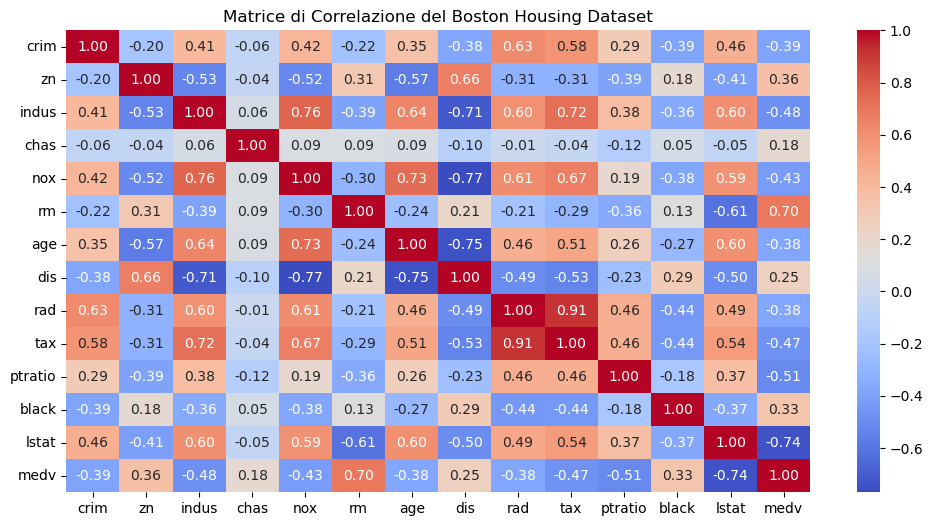

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file_path = 'C:/Users/matte/Downloads/archive/beginner_datasets/boston.csv'
boston_data = pd.read_csv(file_path)

# 1. Media del prezzo delle case in base alla distanza dal fiume Charles
media_prezzo_fiume = boston_data.groupby('chas')['medv'].mean()
print("Media del prezzo delle case in base alla distanza dal fiume Charles:")
print(media_prezzo_fiume)

# 2. Correlazione tra il tasso di criminalità e il valore delle abitazioni
correlazione_crimine_medv = boston_data['crim'].corr(boston_data['medv'])
print(f"\nCorrelazione tra il tasso di criminalità e il valore delle abitazioni: {correlazione_crimine_medv}")

# Spiegazione del risultato
if correlazione_crimine_medv < 0:
    print("C'è una correlazione negativa tra il tasso di criminalità e il valore delle abitazioni, " 
          "il che suggerisce che in genere le aree con un tasso di criminalità più alto hanno valori di abitazione più bassi.")

# 3. Media del numero di stanze rispetto al rapporto alunni-insegnanti e del valore delle case
media_rm_ptratio = boston_data.groupby('ptratio')['rm'].mean()
media_medv_ptratio = boston_data.groupby('ptratio')['medv'].mean()
print("\nMedia del numero di stanze rispetto al rapporto alunni-insegnanti:")
print(media_rm_ptratio)
print("\nMedia del valore delle case rispetto al rapporto alunni-insegnanti:")
print(media_medv_ptratio)

# Correlazione tra RM e MEDV
correlazione_rm_medv = boston_data['rm'].corr(boston_data['medv'])
print(f"\nCorrelazione tra il numero di stanze e il valore delle case: {correlazione_rm_medv}")

if correlazione_rm_medv > 0:
    print("C'è una correlazione positiva tra il numero di stanze e il valore delle case, " 
          "suggerendo che abitazioni con un numero maggiore di stanze tendono ad avere valori più elevati.")

# 4. Media delle età delle abitazioni, numero di stanze e tasse in base all'accessibilità alle autostrade
media_age_rad = boston_data.groupby('rad')['age'].mean()
media_rm_rad = boston_data.groupby('rad')['rm'].mean()
media_tax_rad = boston_data.groupby('rad')['tax'].mean()

print("\nMedia delle età delle abitazioni rispetto all'accessibilità alle autostrade:")
print(media_age_rad)
print("\nMedia del numero di stanze rispetto all'accessibilità alle autostrade:")
print(media_rm_rad)
print("\nMedia delle tasse rispetto all'accessibilità alle autostrade:")
print(media_tax_rad)

# Visualizzazione delle correlazioni tra variabili
plt.figure(figsize=(12, 6))
sns.heatmap(boston_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice di Correlazione del Boston Housing Dataset')
plt.show()

In [16]:
import pandas as pd

# Esercizio 1/3: DataFrame dei dipendenti
employees_df = pd.DataFrame({
    'employee_id': [101, 102, 103, 104, 105],
    'name': ['Alice', 'Bob', 'Charlie', 'David', 'Emma'],
    'department_id': [1, 2, 1, 2, 3]
})

# Esercizio 2/3: DataFrame dei dipartimenti
departments_df = pd.DataFrame({
    'department_id': [1, 2, 3],
    'department_name': ['HR', 'IT', 'Finance'],
    'location': ['New York', 'San Francisco', 'Chicago']
})

# Unione con .merge()
merged_df = employees_df.merge(departments_df, on='department_id', how='inner')
print("Unione con .merge():")
print(merged_df)

# Esercizio 3/3: Trasformare la colonna department_id negli indici
employees_df.set_index('department_id', inplace=True)
departments_df.set_index('department_id', inplace=True)

# Unione con .join()
joined_df = employees_df.join(departments_df, how='inner')
print("\nUnione con .join():")
print(joined_df)

# Verifica le differenze tra i due risultati
if merged_df.equals(joined_df.reset_index()):
    print("\nI risultati delle unioni sono equivalenti.")
else:
    print("\nI risultati delle unioni sono differenti.")


Unione con .merge():
   employee_id     name  department_id department_name       location
0          101    Alice              1              HR       New York
1          102      Bob              2              IT  San Francisco
2          103  Charlie              1              HR       New York
3          104    David              2              IT  San Francisco
4          105     Emma              3         Finance        Chicago

Unione con .join():
               employee_id     name department_name       location
department_id                                                     
1                      101    Alice              HR       New York
2                      102      Bob              IT  San Francisco
1                      103  Charlie              HR       New York
2                      104    David              IT  San Francisco
3                      105     Emma         Finance        Chicago

I risultati delle unioni sono differenti.


In [3]:
# --------------------------------------------------------------
# 1️⃣  Install dependencies (run once)
# --------------------------------------------------------------
!pip install pandas sqlalchemy mysql-connector-python -q

# --------------------------------------------------------------
# 2️⃣  Imports
# --------------------------------------------------------------
import pandas as pd
import pyodbc
from sqlalchemy import create_engine

# --------------------------------------------------------------
# 3️⃣  Build the SQLAlchemy engine
# --------------------------------------------------------------
def get_engine():
    user = "studente_dapt"
    password = "Ep1c0d3!!D4t4**4n4lys1s"
    host = "epicode-data-pt-mysql.cvetyjye2qbl.eu-central-1.rds.amazonaws.com"
    port = 3306
    db   = "AdventureWorksDW"

    uri = f"mysql+mysqlconnector://{user}:{password}@{host}:{port}/{db}"
    engine = create_engine(uri, echo=False)   # echo=False disables verbose SQL logging
    return engine

engine = get_engine()          # keep the engine alive for the whole cell

# --------------------------------------------------------------
# 4️⃣  Helper that runs a SQL statement and returns a pandas DataFrame
# --------------------------------------------------------------
def run_query(engine, sql):
    """Execute *sql* on the supplied engine and return a DataFrame."""
    return pd.read_sql(sql, con=engine)

# Importiamo le tabelle come DataFrame
dim_employee = pd.read_sql('SELECT * FROM dimemployee', con=engine)
dim_sales_territory = pd.read_sql('SELECT * FROM dimemployeesalesterritory', con=engine)

# Effettuiamo un join tra i due DataFrame usando le colonne EmployeeKey
merged_df = dim_employee.merge(dim_sales_territory, on='EmployeeKey', how='inner')
print(f"Dimensione del DataFrame risultante dalla join: {merged_df.shape}")

# Importiamo la tabella dimsalesterritory
dim_sales_territory_data = pd.read_sql('SELECT * FROM dimsalesterritory', con=engine)

# Effettuiamo un join tra il DataFrame risultante e dimsalesterritory
final_df = merged_df.merge(dim_sales_territory_data, on='SalesTerritoryKey', how='inner')

# Count dei dipendenti per country e region
count_by_country_region = final_df.groupby(['SalesTerritoryCountry', 'SalesTerritoryRegion']).size().reset_index(name='EmployeeCount')
print("\nNumero di dipendenti per country e region:")
print(count_by_country_region)

# Valutiamo la media del BaseRate per ogni paese
average_base_rate = final_df.groupby('SalesTerritoryCountry')['BaseRate'].mean().reset_index()
print("\nMedia del BaseRate per ogni paese:")
print(average_base_rate)

# --------------------------------------------------------------
# 9️⃣  Clean‑up
# --------------------------------------------------------------
engine.dispose()

Dimensione del DataFrame risultante dalla join: (39, 29)

Numero di dipendenti per country e region:
  SalesTerritoryCountry SalesTerritoryRegion  EmployeeCount
0             Australia            Australia              3
1                Canada               Canada              4
2                France               France              4
3               Germany              Germany              3
4        United Kingdom       United Kingdom              3
5         United States              Central              5
6         United States            Northeast              3
7         United States            Northwest              5
8         United States            Southeast              4
9         United States            Southwest              5

Media del BaseRate per ogni paese:
  SalesTerritoryCountry   BaseRate
0             Australia  47.764433
1                Canada  41.592550
2                France  41.592550
3               Germany  47.764433
4        United Kingdom  47.